<a href="https://colab.research.google.com/github/podo47/DL_HW3_Pytorch_TF/blob/main/DL_HW3_LeNet5_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow

## Mount to drive

In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


## Import library

In [ ]:
import os
import math
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from PIL import Image
import cv2
import time
import pickle


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import CSVLogger

#!pip install tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

#!pip install keras-flops
from keras_flops import get_flops

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Show matplotlib graphs in your notebook
%matplotlib inline

## Load data

In [5]:
train = pd.read_csv('/content/drive/MyDrive/images/train.txt', sep=" ",header=None)
train_y = np.array(train[1])

valid = pd.read_csv('/content/drive/MyDrive/images/val.txt', sep=" ",header=None)
valid_y = np.array(valid[1])

test = pd.read_csv('/content/drive/MyDrive/images/test.txt', sep=" ",header=None)
test_dir = np.array(test[0])
test_y = np.array(test[1])

In [6]:
with np.load("/content/drive/MyDrive/images/rgb_dataset.npz") as data:
    X_train = data["traindata"]
    X_valid = data["validdata"]
    X_test = data["testdata"]

In [7]:
print('X_train shape : ', X_train.shape)
print('X_valid shape : ',X_valid.shape)
print('X_test shape : ',X_test.shape)

X_train shape :  (63325, 28, 28, 3)
X_valid shape :  (450, 28, 28, 3)
X_test shape :  (450, 28, 28, 3)


## Define dataset

In [8]:
X_train, train_y = tf.cast(X_train, tf.float32)/255.0, tf.cast(train_y, tf.int32)
X_valid, valid_y = tf.cast(X_valid, tf.float32)/255.0, tf.cast(valid_y, tf.int32)
X_test, test_y = tf.cast(X_test, tf.float32)/255.0, tf.cast(test_y, tf.int32)

train_data = tf.data.Dataset.from_tensor_slices((X_train, train_y))
valid_data = tf.data.Dataset.from_tensor_slices((X_valid, valid_y))
test_data = tf.data.Dataset.from_tensor_slices((X_test, test_y))

### Data augmentation

In [9]:
# Normalization
def transform1(image, label): 
    image = (image - 0.5)/0.5  
    return image, label

# Randomly adjust the brightness
def transform2(image, label):
    image = tf.image.random_brightness(image, max_delta=0.2)  
    image = (image - 0.5)/0.5
    return image, label

# Adjust the contrast
def transform3(image, label):
    image = tf.image.adjust_contrast(image, 2.0)
    image = (image - 0.5)/0.5
    return image, label

# Flipping: horizontally flip the images.
def transform4(image, label):
    image = tf.image.random_flip_left_right(image)  
    image = (image - 0.5)/0.5
    return image, label

augmented_dataset = []
augmented_dataset.append(train_data.map(transform1))
augmented_dataset.append(train_data.map(transform2))
augmented_dataset.append(train_data.map(transform3))
augmented_dataset.append(train_data.map(transform4))

train_dataset = augmented_dataset[0]
for dataset in augmented_dataset[1:]:
    train_dataset = train_dataset.concatenate(dataset)
valid_dataset = valid_data.map(transform1)
test_dataset = test_data.map(transform1)

### Dataset

In [10]:
# Shuffle
train_dataset = train_dataset.shuffle(buffer_size=50000)
 
train_dataset = train_dataset.batch(256)
valid_dataset = valid_dataset.batch(450)
test_dataset = test_dataset.batch(450)

## LeNet5

In [11]:
def LeNet5():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(6, kernel_size=(5, 5), activation='sigmoid', input_shape=(28, 28, 3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(16, kernel_size=(5, 5), activation='sigmoid'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='sigmoid'),
        tf.keras.layers.Dense(84, activation='sigmoid'),
        tf.keras.layers.Dense(50, activation='softmax')])
    
    return model

In [ ]:
lenet5 = LeNet5()
lenet5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 24, 24, 6)         456       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 6)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 120)               3

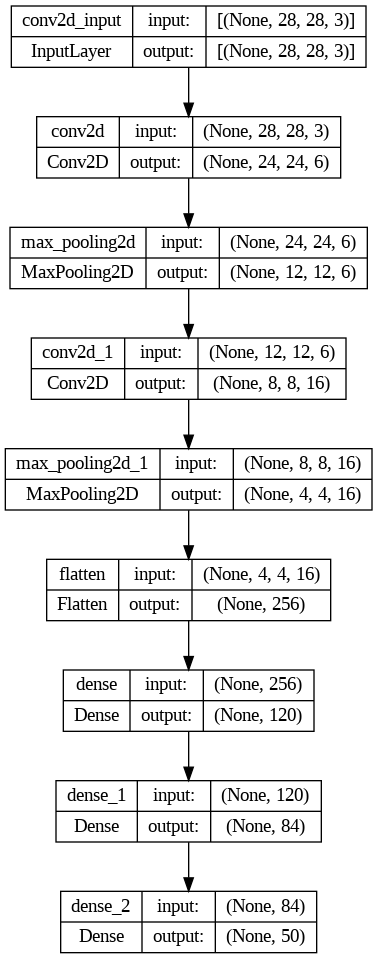

In [ ]:
plot_model(lenet5, to_file='/content/drive/MyDrive/DL/HW3/LeNet5_tf/LeNet5_model.png', show_shapes=True)

## Train

### Define a loss function and optimizer

In [ ]:
lenet5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

### Train the network

In [ ]:
n_epoch = 25
csv_logger = CSVLogger('/content/drive/MyDrive/DL/HW3/LeNet5_tf/training_log.csv')

t1=time.time()
history = lenet5.fit(train_dataset, validation_data=valid_dataset, epochs=n_epoch, callbacks=[csv_logger])
print("Total time used:", time.time() - t1, "sec")

Epoch 1/25
990/990 [==============================] - 25s 21ms/step - loss: 3.7073 - sparse_categorical_accuracy: 0.0601 - val_loss: 3.5426 - val_sparse_categorical_accuracy: 0.0844
Epoch 2/25
990/990 [==============================] - 21s 20ms/step - loss: 3.3283 - sparse_categorical_accuracy: 0.1237 - val_loss: 3.3193 - val_sparse_categorical_accuracy: 0.1222
Epoch 3/25
990/990 [==============================] - 23s 22ms/step - loss: 3.1880 - sparse_categorical_accuracy: 0.1498 - val_loss: 3.2303 - val_sparse_categorical_accuracy: 0.1333
Epoch 4/25
990/990 [==============================] - 19s 17ms/step - loss: 3.1221 - sparse_categorical_accuracy: 0.1623 - val_loss: 3.2427 - val_sparse_categorical_accuracy: 0.1311
Epoch 5/25
990/990 [==============================] - 19s 17ms/step - loss: 3.0775 - sparse_categorical_accuracy: 0.1719 - val_loss: 3.1703 - val_sparse_categorical_accuracy: 0.1422
Epoch 6/25
990/990 [==============================] - 21s 19ms/step - loss: 3.0397 - spars

### Show performance

In [ ]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


Loss

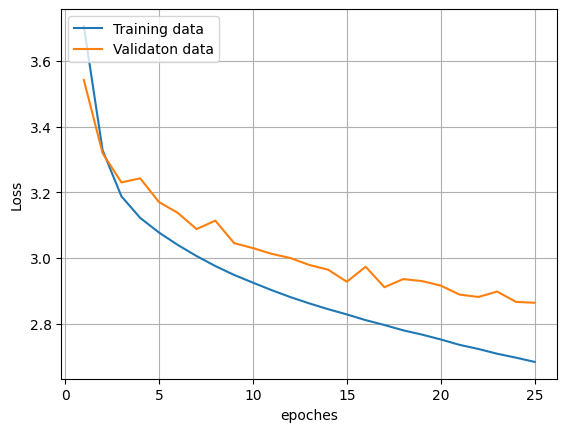

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

x = np.arange(1, n_epoch + 1)
plt.xlabel("epoches")
plt.ylabel("Loss")
plt.plot(x, train_loss)
plt.plot(x, val_loss)
plt.grid(True)
plt.legend(["Training data", "Validaton data"], loc = "upper left")
plt.savefig("/content/drive/MyDrive/DL/HW3/LeNet5_tf/LeNet5_loss_tf.png")
plt.show()

Accuracy

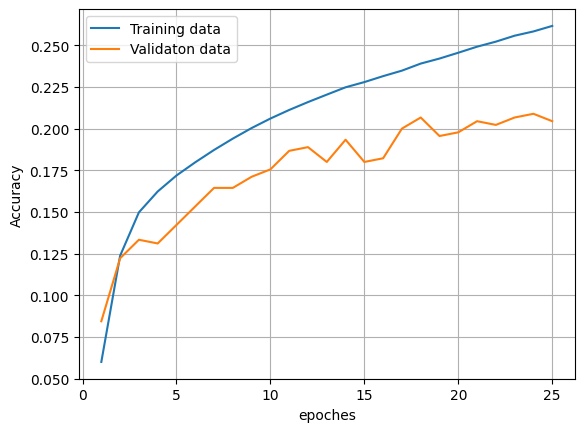

In [ ]:
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

x = np.arange(1, n_epoch + 1)
plt.xlabel("epoches")
plt.ylabel("Accuracy")
plt.plot(x, train_acc)
plt.plot(x, val_acc)
plt.grid(True)
plt.legend(["Training data", "Validaton data"], loc = "upper left")
plt.savefig("/content/drive/MyDrive/DL/HW3/LeNet5_tf/LeNet5_acc_tf.png")
plt.show()

Space Complexity

In [15]:
lenet5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 24, 24, 6)         456       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 6)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 120)               3

Flop

In [13]:
flops = get_flops(lenet5, batch_size=256)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


FLOPS: 0.237 G


### Optional : Save the trained model

In [ ]:
PATH_lenet5_tf = '/content/drive/MyDrive/DL/HW3/LeNet5_tf/lenet5_tf.h5'

In [ ]:
# Save the model.
lenet5.save(PATH_lenet5_tf)

## Test

### Load back in saved model

In [12]:
PATH_lenet5_tf = '/content/drive/MyDrive/DL/HW3/LeNet5_tf/lenet5_tf.h5'
lenet5 = tf.keras.models.load_model(PATH_lenet5_tf)

### Evaluate on testing set

In [ ]:
test_loss, test_accuracy = lenet5.evaluate(test_dataset)

print('Test Loss:', round(test_loss, 4))
print('Test Accuracy:', round(test_accuracy, 4))

1/1 [==============================] - 1s 600ms/step - loss: 2.8524 - sparse_categorical_accuracy: 0.2489
Test Loss: 2.8524
Test Accuracy: 0.2489


In [ ]:
t1 = time.time()
prediction = lenet5.predict(test_dataset)
print("Total time used:", time.time() - t1, "sec")
lenet5_test_pred = tf.argmax(prediction, axis=1).numpy()

1/1 [==============================] - 0s 420ms/step
Total time used: 0.4450962543487549 sec


In [ ]:
def answer(test_y, test_y_pred, data_name, output_name):
  df = np.column_stack((test_y, test_y_pred))
  test_result = pd.DataFrame(df, index=data_name, columns=['Answer','Prediction'])
  test_result.to_csv('/content/drive/MyDrive/DL/HW3/LeNet5_tf/' + output_name + '_test_result.csv')
  return test_result

In [ ]:
output_name = 'LeNet5_tf'
LeNet5_answer = answer(test_y, lenet5_test_pred, test_dir, output_name)
LeNet5_answer

,Answer,Prediction
images/n02111277/n02111277_9420.JPEG,0,48
images/n02111277/n02111277_9422.JPEG,0,31
images/n02111277/n02111277_9484.JPEG,0,46
images/n02111277/n02111277_951.JPEG,0,41
images/n02111277/n02111277_9518.JPEG,0,39
...,...,...
images/n02172182/n02172182_974.JPEG,49,49
images/n02172182/n02172182_9765.JPEG,49,44
images/n02172182/n02172182_9789.JPEG,49,49
images/n02172182/n02172182_98.JPEG,49,46


# Static

### Static LeNet5

In [ ]:
class LeNet5_Static(tf.keras.Model):
    def __init__(self):
        super(LeNet5_Static, self).__init__(name='LeNet5_Static', dynamic = False)
        self.conv_layer_1 = tf.keras.layers.Conv2D(filters = 6, kernel_size = (5, 5), input_shape=(28, 28, 3), padding="valid", activation='sigmoid')
        self.pool_layer_1 = tf.keras.layers.MaxPool2D(2,2)
        self.conv_layer_2 = tf.keras.layers.Conv2D(filters = 16, kernel_size = (5, 5), padding="valid", activation='sigmoid')        
        self.pool_layer_2 = tf.keras.layers.MaxPool2D(2,2)
        self.conv_layer_3 = tf.keras.layers.Conv2D(filters = 120, kernel_size = (5, 5), padding="valid", activation='sigmoid')        
        self.fc_layer_1 = tf.keras.layers.Flatten()
        self.fc_layer_2 = tf.keras.layers.Dense(84, activation="sigmoid")
        self.fc_layer_3 = tf.keras.layers.Dense(50, activation="softmax")
    
    def call(self, inputs):
        activation = self.conv_layer_1(inputs)
        activation = self.pool_layer_1(activation)
        activation = self.conv_layer_2(activation)
        activation = self.pool_layer_2(activation)
        activation = self.fc_layer_1(activation)
        activation = self.fc_layer_2(activation)
        output = self.fc_layer_3(activation)
        return output

In [ ]:
lenet5_s = LeNet5_Static()

## Train

### Define a loss function and optimizer

In [ ]:
lenet5_s.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

### Train the network

In [ ]:
n_epoch = 25
csv_logger_s = CSVLogger('/content/drive/MyDrive/DL/HW3/LeNet5_tf/static/training_log_static.csv')

t1=time.time()
history_s = lenet5_s.fit(train_dataset, validation_data=valid_dataset, epochs=n_epoch, callbacks=[csv_logger_s])
print("Total time used:", time.time() - t1, "sec")

Epoch 1/25
990/990 [==============================] - 31s 17ms/step - loss: 3.6794 - sparse_categorical_accuracy: 0.0674 - val_loss: 3.5498 - val_sparse_categorical_accuracy: 0.0978
Epoch 2/25
990/990 [==============================] - 20s 17ms/step - loss: 3.3145 - sparse_categorical_accuracy: 0.1304 - val_loss: 3.3072 - val_sparse_categorical_accuracy: 0.1289
Epoch 3/25
990/990 [==============================] - 19s 17ms/step - loss: 3.1727 - sparse_categorical_accuracy: 0.1569 - val_loss: 3.2236 - val_sparse_categorical_accuracy: 0.1422
Epoch 4/25
990/990 [==============================] - 21s 16ms/step - loss: 3.1005 - sparse_categorical_accuracy: 0.1729 - val_loss: 3.1683 - val_sparse_categorical_accuracy: 0.1644
Epoch 5/25
990/990 [==============================] - 18s 17ms/step - loss: 3.0506 - sparse_categorical_accuracy: 0.1823 - val_loss: 3.1403 - val_sparse_categorical_accuracy: 0.1778
Epoch 6/25
990/990 [==============================] - 20s 19ms/step - loss: 3.0121 - spars

### Show performance

In [ ]:
history_dict_s = history_s.history
print(history_dict_s.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


Loss

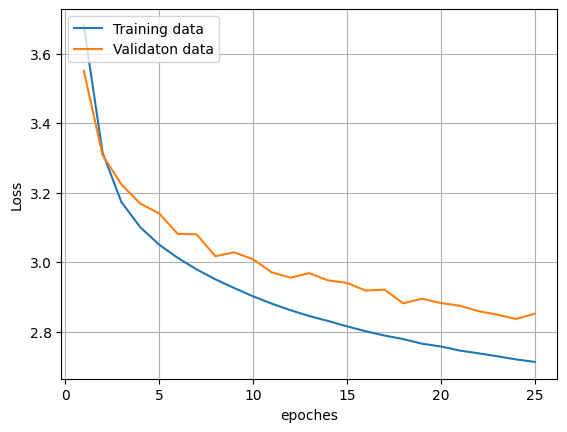

In [ ]:
train_loss_s = history_s.history['loss']
val_loss_s = history_s.history['val_loss']

x = np.arange(1, n_epoch + 1)
plt.xlabel("epoches")
plt.ylabel("Loss")
plt.plot(x, train_loss_s)
plt.plot(x, val_loss_s)
plt.grid(True)
plt.legend(["Training data", "Validaton data"], loc = "upper left")
plt.savefig("/content/drive/MyDrive/DL/HW3/LeNet5_tf/static/LeNet5_loss_tf_static.png")
plt.show()

Accuracy

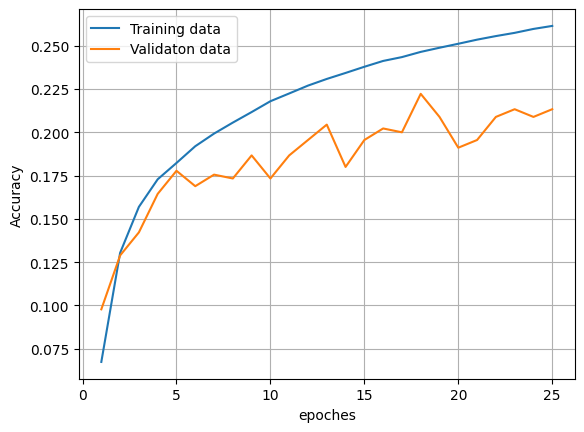

In [ ]:
train_acc_s = history_s.history['sparse_categorical_accuracy']
val_acc_s = history_s.history['val_sparse_categorical_accuracy']

x = np.arange(1, n_epoch + 1)
plt.xlabel("epoches")
plt.ylabel("Accuracy")
plt.plot(x, train_acc_s)
plt.plot(x, val_acc_s)
plt.grid(True)
plt.legend(["Training data", "Validaton data"], loc = "upper left")
plt.savefig("/content/drive/MyDrive/DL/HW3/LeNet5_tf/static/LeNet5_acc_tf_static.png")
plt.show()

Flop

In [ ]:
def get_flops(model):
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

    flops = tf.compat.v1.profiler.profile(graph=tf.compat.v1.keras.backend.get_session().graph,
                                          run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops

print(get_flops(lenet5_s))

0


### Optional : Save the trained model

In [ ]:
PATH_lenet5_tf_s = '/content/drive/MyDrive/DL/HW3/LeNet5_tf/static/lenet5_tf_s'

In [ ]:
# Save the model.
lenet5_s.save(PATH_lenet5_tf_s, save_format='tf')

## Test

### Load back in saved model

In [30]:
PATH_lenet5_tf_s = '/content/drive/MyDrive/DL/HW3/LeNet5_tf/static/lenet5_tf_s'
lenet5_s = tf.keras.models.load_model(PATH_lenet5_tf_s)

### Evaluate on testing set

In [ ]:
test_loss_s, test_accuracy_s = lenet5_s.evaluate(test_dataset)

print('Test Loss:', round(test_loss_s, 4))
print('Test Accuracy:', round(test_accuracy_s, 4))

1/1 [==============================] - 1s 1s/step - loss: 2.8488 - sparse_categorical_accuracy: 0.2289
Test Loss: 2.8488
Test Accuracy: 0.2289


In [31]:
t1 = time.time()
prediction_s = lenet5_s.predict(test_dataset)
print("Total time used:", time.time() - t1, "sec")
lenet5_test_pred_s = tf.argmax(prediction_s, axis=1).numpy()

1/1 [==============================] - 0s 85ms/step
Total time used: 0.09579825401306152 sec


In [ ]:
def answer(test_y, test_y_pred, data_name, output_name):
  df = np.column_stack((test_y, test_y_pred))
  test_result = pd.DataFrame(df, index=data_name, columns=['Answer','Prediction'])
  test_result.to_csv('/content/drive/MyDrive/DL/HW3/LeNet5_tf/static/' + output_name + '_test_result_static.csv')
  return test_result

In [ ]:
output_name = 'LeNet5_tf'
LeNet5_answer_s = answer(test_y, lenet5_test_pred_s, test_dir, output_name)
LeNet5_answer_s

,Answer,Prediction
images/n02111277/n02111277_9420.JPEG,0,48
images/n02111277/n02111277_9422.JPEG,0,29
images/n02111277/n02111277_9484.JPEG,0,46
images/n02111277/n02111277_951.JPEG,0,0
images/n02111277/n02111277_9518.JPEG,0,39
...,...,...
images/n02172182/n02172182_974.JPEG,49,49
images/n02172182/n02172182_9765.JPEG,49,44
images/n02172182/n02172182_9789.JPEG,49,46
images/n02172182/n02172182_98.JPEG,49,46


# Dynamic

### Dynamic LeNet5

In [ ]:
class LeNet5_Dynamic(tf.keras.Model):
    def __init__(self):
        super(LeNet5_Dynamic, self).__init__(name='LeNet5_Dynamic', dynamic = True)
        self.conv_layer_1 = tf.keras.layers.Conv2D(filters = 6, kernel_size = (5, 5), input_shape=(28, 28, 3), padding="valid", activation='sigmoid')
        self.pool_layer_1 = tf.keras.layers.MaxPool2D(2,2)
        self.conv_layer_2 = tf.keras.layers.Conv2D(filters = 16, kernel_size = (5, 5), padding="valid", activation='sigmoid')        
        self.pool_layer_2 = tf.keras.layers.MaxPool2D(2,2)
        self.conv_layer_3 = tf.keras.layers.Conv2D(filters = 120, kernel_size = (5, 5), padding="valid", activation='sigmoid')        
        self.fc_layer_1 = tf.keras.layers.Flatten()
        self.fc_layer_2 = tf.keras.layers.Dense(84, activation="sigmoid")
        self.fc_layer_3 = tf.keras.layers.Dense(50, activation="softmax")
    
    def call(self, inputs):
        activation = self.conv_layer_1(inputs)
        activation = self.pool_layer_1(activation)
        activation = self.conv_layer_2(activation)
        activation = self.pool_layer_2(activation)
        activation = self.fc_layer_1(activation)
        activation = self.fc_layer_2(activation)
        output = self.fc_layer_3(activation)
        return output

In [ ]:
lenet5_d = LeNet5_Dynamic()

## Train

### Define a loss function and optimizer

In [ ]:
lenet5_d.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

### Train the network

In [ ]:
n_epoch = 25
csv_logger_d = CSVLogger('/content/drive/MyDrive/DL/HW3/LeNet5_tf/dynamic/training_log_dynamic.csv')

t1=time.time()
history_d = lenet5_d.fit(train_dataset, validation_data=valid_dataset, epochs=n_epoch, callbacks=[csv_logger_d])
print("Total time used:", time.time() - t1, "sec")

Epoch 1/25


990/990 [==============================] - 74s 71ms/step - loss: 3.6734 - sparse_categorical_accuracy: 0.0689 - val_loss: 3.5558 - val_sparse_categorical_accuracy: 0.0889
Epoch 2/25
990/990 [==============================] - 63s 62ms/step - loss: 3.3030 - sparse_categorical_accuracy: 0.1337 - val_loss: 3.3065 - val_sparse_categorical_accuracy: 0.1311
Epoch 3/25
990/990 [==============================] - 61s 59ms/step - loss: 3.1579 - sparse_categorical_accuracy: 0.1607 - val_loss: 3.2236 - val_sparse_categorical_accuracy: 0.1244
Epoch 4/25
990/990 [==============================] - 59s 58ms/step - loss: 3.0901 - sparse_categorical_accuracy: 0.1751 - val_loss: 3.2108 - val_sparse_categorical_accuracy: 0.1578
Epoch 5/25
990/990 [==============================] - 57s 56ms/step - loss: 3.0408 - sparse_categorical_accuracy: 0.1858 - val_loss: 3.1322 - val_sparse_categorical_accuracy: 0.1556
Epoch 6/25
990/990 [==============================] - 63s 62ms/step - loss: 3.0006 - sparse_categoric

### Show performance

In [ ]:
history_dict_d = history_d.history
print(history_dict_d.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


Loss

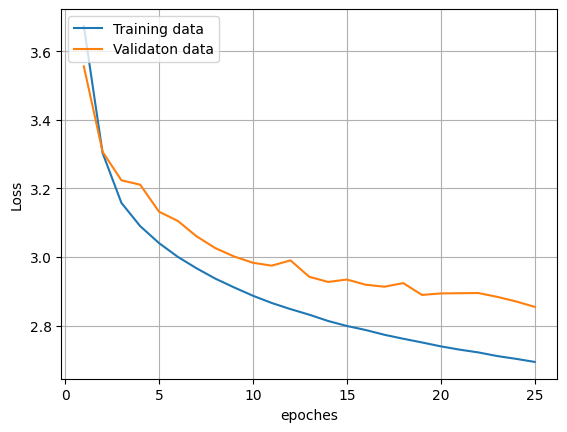

In [ ]:
train_loss_d = history_d.history['loss']
val_loss_d = history_d.history['val_loss']

x = np.arange(1, n_epoch + 1)
plt.xlabel("epoches")
plt.ylabel("Loss")
plt.plot(x, train_loss_d)
plt.plot(x, val_loss_d)
plt.grid(True)
plt.legend(["Training data", "Validaton data"], loc = "upper left")
plt.savefig("/content/drive/MyDrive/DL/HW3/LeNet5_tf/dynamic/LeNet5_loss_tf_dynamic.png")
plt.show()

Accuracy

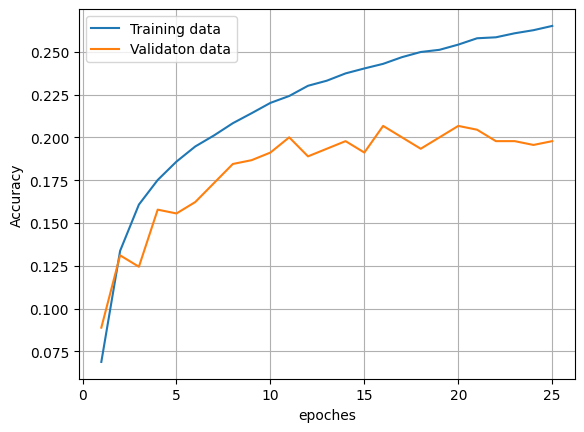

In [ ]:
train_acc_d = history_d.history['sparse_categorical_accuracy']
val_acc_d = history_d.history['val_sparse_categorical_accuracy']

x = np.arange(1, n_epoch + 1)
plt.xlabel("epoches")
plt.ylabel("Accuracy")
plt.plot(x, train_acc_d)
plt.plot(x, val_acc_d)
plt.grid(True)
plt.legend(["Training data", "Validaton data"], loc = "upper left")
plt.savefig("/content/drive/MyDrive/DL/HW3/LeNet5_tf/dynamic/LeNet5_acc_tf_dynamic.png")
plt.show()

Flop

In [ ]:
def count_flops(model):
    signature = profiler.ProfileOptionBuilder.float_operation()
    flops = profiler.profile(tf.profiler.experimental.stop(), run_meta=signature)
    return flops.total_float_ops

flops = count_flops(lenet5_d)
print(f"Total FLOPs: {flops / 10**9} G FLOPs")

### Optional : Save the trained model

In [ ]:
PATH_lenet5_tf_d = '/content/drive/MyDrive/DL/HW3/LeNet5_tf/dynamic/lenet5_tf_d'

In [ ]:
# Save the model.
lenet5_d.save(PATH_lenet5_tf_d)

## Test

### Load back in saved model

In [32]:
PATH_lenet5_tf_d = '/content/drive/MyDrive/DL/HW3/LeNet5_tf/dynamic/lenet5_tf_d'
lenet5_d = tf.keras.models.load_model(PATH_lenet5_tf_d)

### Evaluate on testing set

In [ ]:
test_loss_d, test_accuracy_d = lenet5_d.evaluate(test_dataset)

print('Test Loss:', round(test_loss_d, 4))
print('Test Accuracy:', round(test_accuracy_d, 4))

1/1 [==============================] - 1s 902ms/step - loss: 2.8465 - sparse_categorical_accuracy: 0.2444
Test Loss: 2.8465
Test Accuracy: 0.2444


In [33]:
t1 = time.time()
prediction_d = lenet5_d.predict(test_dataset)
print("Total time used:", time.time() - t1, "sec")
lenet5_test_pred_d = tf.argmax(prediction_d, axis=1).numpy()

1/1 [==============================] - 0s 78ms/step
Total time used: 0.08969545364379883 sec


In [ ]:
def answer(test_y, test_y_pred, data_name, output_name):
  df = np.column_stack((test_y, test_y_pred))
  test_result = pd.DataFrame(df, index=data_name, columns=['Answer','Prediction'])
  test_result.to_csv('/content/drive/MyDrive/DL/HW3/LeNet5_tf/dynamic/' + output_name + '_test_result_dynamic.csv')
  return test_result

In [ ]:
output_name = 'LeNet5_tf'
LeNet5_answer_d = answer(test_y, lenet5_test_pred_d, test_dir, output_name)
LeNet5_answer_d

,Answer,Prediction
images/n02111277/n02111277_9420.JPEG,0,48
images/n02111277/n02111277_9422.JPEG,0,31
images/n02111277/n02111277_9484.JPEG,0,5
images/n02111277/n02111277_951.JPEG,0,0
images/n02111277/n02111277_9518.JPEG,0,46
...,...,...
images/n02172182/n02172182_974.JPEG,49,49
images/n02172182/n02172182_9765.JPEG,49,44
images/n02172182/n02172182_9789.JPEG,49,49
images/n02172182/n02172182_98.JPEG,49,46


# Model compression

## Quantization

In [17]:
lenet5 = LeNet5()
lenet5_q = tfmot.quantization.keras.quantize_model(lenet5)
lenet5_q.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 28, 28, 3)        3         
 er)                                                             
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 24, 24, 6)        471       
 erV2)                                                           
                                                                 
 quant_max_pooling2d (Quanti  (None, 12, 12, 6)        1         
 zeWrapperV2)                                                    
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 8, 8, 16)         2451      
 pperV2)                                                         
                                                                 
 quant_max_pooling2d_1 (Quan  (None, 4, 4, 16)         1

## Train

### Define a loss function and optimizer

In [18]:
lenet5_q.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

### Train the network

In [19]:
n_epoch = 25
csv_logger_q = CSVLogger('/content/drive/MyDrive/DL/HW3/LeNet5_tf/quantization/training_log_q.csv')

t1=time.time()
history_q = lenet5_q.fit(train_dataset, validation_data=valid_dataset, epochs=n_epoch, callbacks=[csv_logger_q])
print("Total time used:", time.time() - t1, "sec")

Epoch 1/25
990/990 [==============================] - 43s 28ms/step - loss: 3.6760 - sparse_categorical_accuracy: 0.0648 - val_loss: 3.5544 - val_sparse_categorical_accuracy: 0.0822
Epoch 2/25
990/990 [==============================] - 20s 17ms/step - loss: 3.3685 - sparse_categorical_accuracy: 0.1170 - val_loss: 3.3737 - val_sparse_categorical_accuracy: 0.1111
Epoch 3/25
990/990 [==============================] - 21s 20ms/step - loss: 3.2518 - sparse_categorical_accuracy: 0.1393 - val_loss: 3.2547 - val_sparse_categorical_accuracy: 0.1200
Epoch 4/25
990/990 [==============================] - 19s 18ms/step - loss: 3.1716 - sparse_categorical_accuracy: 0.1555 - val_loss: 3.1991 - val_sparse_categorical_accuracy: 0.1511
Epoch 5/25
990/990 [==============================] - 17s 16ms/step - loss: 3.1105 - sparse_categorical_accuracy: 0.1672 - val_loss: 3.1425 - val_sparse_categorical_accuracy: 0.1467
Epoch 6/25
990/990 [==============================] - 18s 16ms/step - loss: 3.0693 - spars

### Show performance

In [20]:
history_dict_q = history_q.history
print(history_dict_q.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


Loss

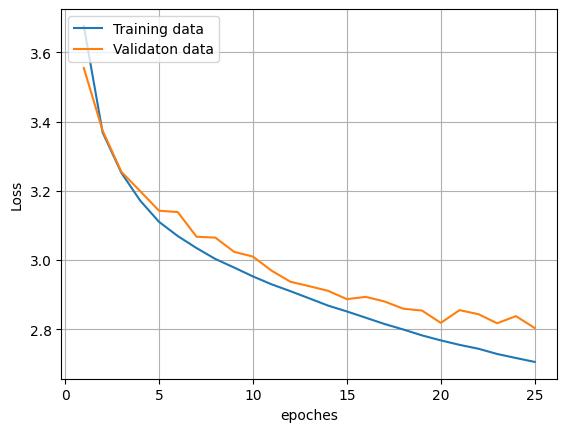

In [21]:
train_loss_q = history_q.history['loss']
val_loss_q = history_q.history['val_loss']

x = np.arange(1, n_epoch + 1)
plt.xlabel("epoches")
plt.ylabel("Loss")
plt.plot(x, train_loss_q)
plt.plot(x, val_loss_q)
plt.grid(True)
plt.legend(["Training data", "Validaton data"], loc = "upper left")
plt.savefig("/content/drive/MyDrive/DL/HW3/LeNet5_tf/quantization/LeNet5_loss_tf_q.png")
plt.show()

Accuracy

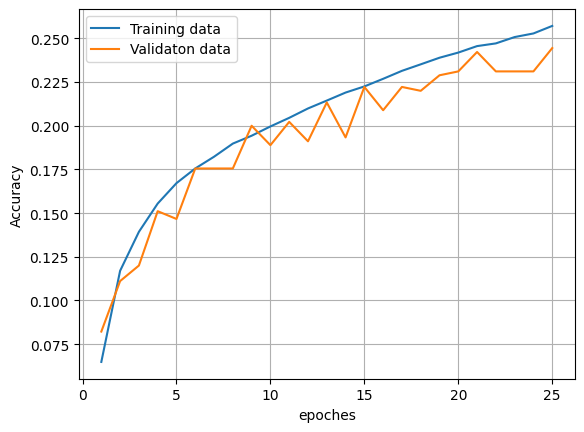

In [22]:
train_acc_q = history_q.history['sparse_categorical_accuracy']
val_acc_q = history_q.history['val_sparse_categorical_accuracy']

x = np.arange(1, n_epoch + 1)
plt.xlabel("epoches")
plt.ylabel("Accuracy")
plt.plot(x, train_acc_q)
plt.plot(x, val_acc_q)
plt.grid(True)
plt.legend(["Training data", "Validaton data"], loc = "upper left")
plt.savefig("/content/drive/MyDrive/DL/HW3/LeNet5_tf/quantization/LeNet5_acc_tf_q.png")
plt.show()

## Test

### Evaluate on testing set

In [23]:
test_loss_q, test_accuracy_q = lenet5_q.evaluate(test_dataset)

print('Test Loss:', round(test_loss_q, 4))
print('Test Accuracy:', round(test_accuracy_q, 4))

1/1 [==============================] - 0s 73ms/step - loss: 2.8396 - sparse_categorical_accuracy: 0.2267
Test Loss: 2.8396
Test Accuracy: 0.2267


In [24]:
t1=time.time()
prediction_q = lenet5_q.predict(test_dataset)
print("Total time used:", time.time() - t1, "sec")
lenet5_test_pred_q = tf.argmax(prediction_q, axis=1).numpy()

1/1 [==============================] - 0s 470ms/step
Total time used: 0.4843873977661133 sec


In [29]:
def answer(test_y, test_y_pred, data_name, output_name):
  df = np.column_stack((test_y, test_y_pred))
  test_result = pd.DataFrame(df, index=data_name, columns=['Answer','Prediction'])
  test_result.to_csv('/content/drive/MyDrive/DL/HW3/LeNet5_tf/quantization/' + output_name + '_test_result_q.csv')
  return test_result

In [28]:
output_name = 'LeNet5_tf'
LeNet5_answer_q = answer(test_y, lenet5_test_pred_q, test_dir, output_name)
LeNet5_answer_q

,Answer,Prediction
images/n02111277/n02111277_9420.JPEG,0,38
images/n02111277/n02111277_9422.JPEG,0,33
images/n02111277/n02111277_9484.JPEG,0,5
images/n02111277/n02111277_951.JPEG,0,41
images/n02111277/n02111277_9518.JPEG,0,49
...,...,...
images/n02172182/n02172182_974.JPEG,49,49
images/n02172182/n02172182_9765.JPEG,49,44
images/n02172182/n02172182_9789.JPEG,49,46
images/n02172182/n02172182_98.JPEG,49,46
